In [2228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import matplotlib as mpl

In [2229]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib


# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [2230]:
def df_processing(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch type to a categorical variable
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

df = df_processing(df_pyb)

In [2231]:
df_statcast_group = pd.read_csv('statcast_2024_grouped.csv')

In [2232]:
import pybaseball as pyb
print(pyb.playerid_lookup('Toglia','Michael'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    toglia    michael     669911  toglm001  toglimi01          25845   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  


In [2233]:
print(pyb.playerid_lookup('Cruz','Oneil'))
batter_id = 669911
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
# df_pyb.head()

#print(df['column_name'].unique())

  name_last name_first  key_mlbam key_retro key_bbref  key_fangraphs  \
0      cruz      oneil     665833  cruzo001  cruzon01          21711   

   mlb_played_first  mlb_played_last  
0            2021.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'fld_scor

In [2234]:
# pd.read_csv('BatterDataFG.csv')
# df_fangraphs = pd.read_csv('BatterDataFG.csv')
# print(df_fangraphs.head())

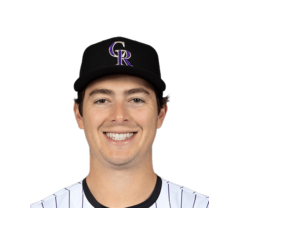

In [2235]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(batter_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{batter_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(batter_id=batter_id, ax=plt.subplots(figsize=(1, 1))[1])

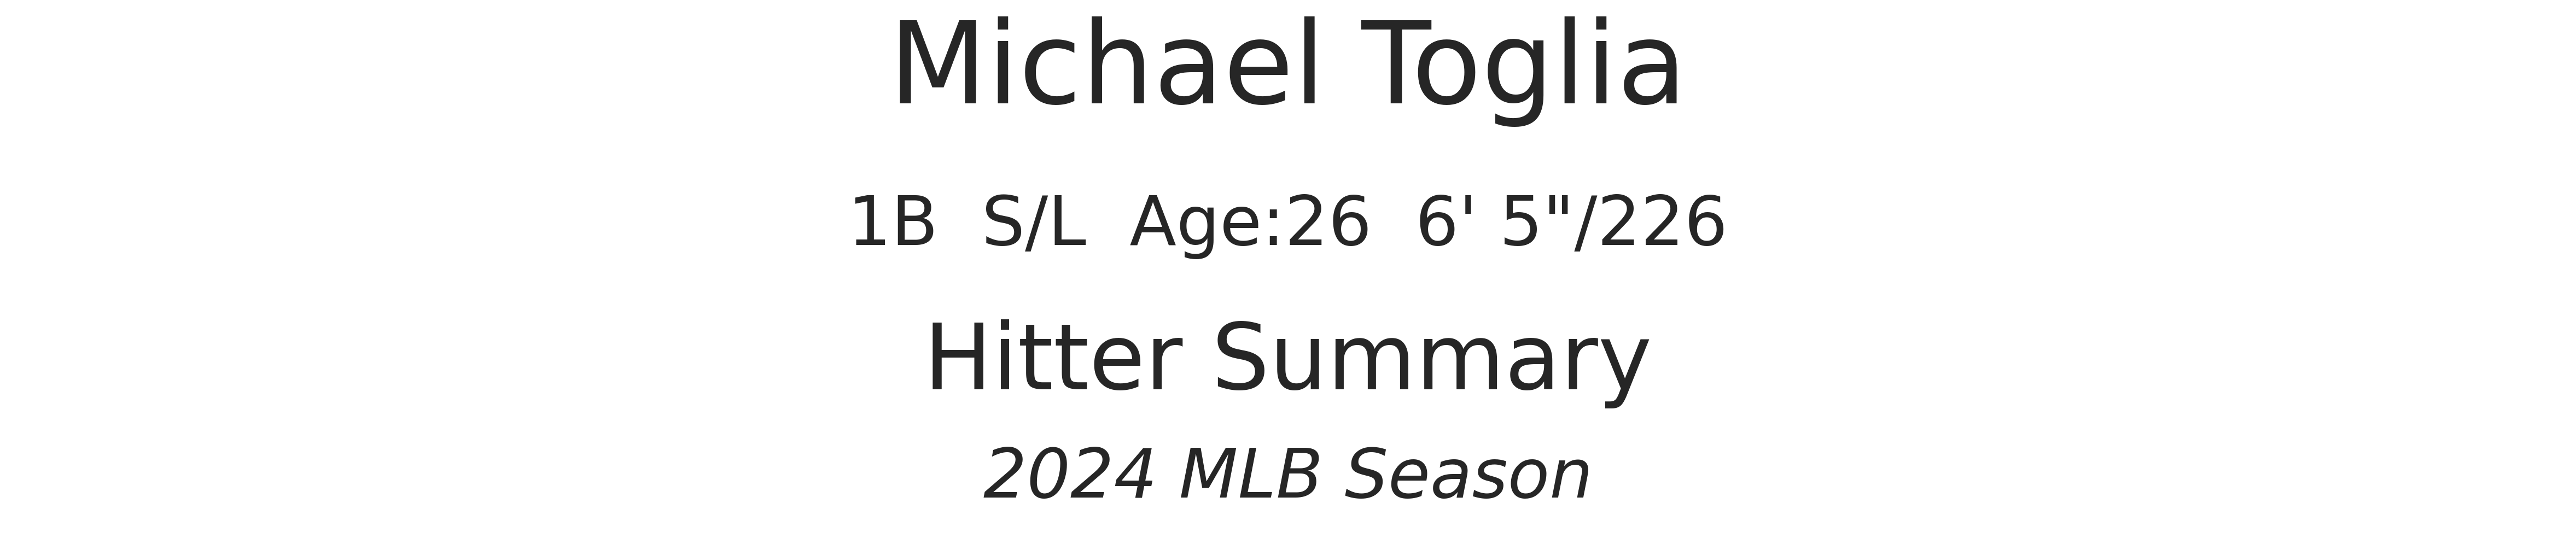

In [2236]:
def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    batter_throw = data['people'][0]['pitchHand']['code']
    batter_hand = data['people'][0]['batSide']['code']
    position = data['people'][0]['primaryPosition']['abbreviation']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']

    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, 1, f'{player_name}', va='top', ha='center', fontsize=50)
    ax.text(0.5, 0.65, f'{position}  {batter_hand}/{batter_throw}  Age:{age}  {height}/{weight}', va='top', ha='center', fontsize=30)
    ax.text(0.5, 0.40, f'Hitter Summary', va='top', ha='center', fontsize=40)
    ax.text(0.5, 0.15, f'2024 MLB Season', va='top', ha='center', fontsize=30, fontstyle='italic')

    # Turn off the axis
    ax.axis('off')

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(batter_id, ax=plt.subplots(figsize=(20, 4))[1])

In [2237]:
import requests

def fangraphs_batting_leaderboards(season: int):
    url = f"https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=bat&lg=all&season={season}&season1={season}&ind=0&qual=0&type=0&month=0&pageitems=500000"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['data'])
    return df

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=2024)
pd.set_option('display.max_columns', None)

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=2024)
print(list(df_fangraphs.columns))

['Bats', 'xMLBAMID', 'Name', 'Team', 'Season', 'Age', 'AgeR', 'SeasonMin', 'SeasonMax', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'TTO%', 'wOBA', 'wRAA', 'wRC', 'Batting', 'Fielding', 'Replacement', 'Positional', 'wLeague', 'CFraming', 'Defense', 'Offense', 'RAR', 'WAR', 'WAROld', 'Dollars', 'BaseRunning', 'Spd', 'wRC+', 'wBsR', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'phLI', 'PH', 'WPA/LI', 'Clutch', 'FB%1', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-

In [2238]:
import pandas as pd

# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team": "NYY", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nyy.png&h=500&w=500"},
    {"team": "OAK", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team": "SD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sd.png&h=500&w=500"},
    {"team": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Create a DataFrame from the list of dictionaries
df_image = pd.DataFrame(mlb_teams)
image_dict = df_image.set_index('team')['logo_url'].to_dict()

In [2239]:
import requests

def get_mlb_team_abbr(batter_id: int) -> str:
    """Fetch the MLB team abbreviation for a given player, filtering out non-MLB teams."""
    
    # Step 1: Request player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"
    data = requests.get(url).json()

    # Debugging: Print raw response
    print("Raw API Response:", data)

    # Step 2: Extract the current team details
    if 'people' in data and data['people']:
        current_team = data['people'][0].get('currentTeam', {})

        # If the current team exists, fetch its full details
        if 'link' in current_team:
            team_url = f"https://statsapi.mlb.com{current_team['link']}"
            team_data = requests.get(team_url).json()

            # Debugging: Print team data
            print("Team Data:", team_data)

            # Step 3: Check if the team belongs to MLB (sport ID = 1)
            if 'teams' in team_data and team_data['teams']:
                team_info = team_data['teams'][0]
                if team_info.get('sport', {}).get('id') == 1:  # Ensure it's MLB
                    return team_info.get('abbreviation', 'Unknown')
    
    return None  # Return None if no MLB team is found

# Example
batter_id = batter_id  # Oneil Cruz
mlb_team = get_mlb_team_abbr(batter_id)
print(f"MLB Team: {mlb_team}")  # Should return 'PIT'


Raw API Response: {'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'people': [{'id': 669911, 'fullName': 'Michael Toglia', 'link': '/api/v1/people/669911', 'firstName': 'Michael', 'lastName': 'Toglia', 'primaryNumber': '4', 'birthDate': '1998-08-16', 'currentAge': 26, 'birthCity': 'Phoenix', 'birthStateProvince': 'AZ', 'birthCountry': 'USA', 'height': '6\' 5"', 'weight': 226, 'active': True, 'currentTeam': {'id': 115, 'name': 'Colorado Rockies', 'link': '/api/v1/teams/115'}, 'primaryPosition': {'code': '3', 'name': 'First Base', 'type': 'Infielder', 'abbreviation': '1B'}, 'useName': 'Michael', 'useLastName': 'Toglia', 'middleName': 'Anthony', 'boxscoreName': 'Toglia', 'gender': 'M', 'isPlayer': True, 'isVerified': True, 'draftYear': 2019, 'mlbDebutDate': '2022-08-30', 'batSide': {'code': 'S', 'description': 'Switch'}, 'pitchHand': {'code': 'L', 'descripti

In [2240]:

# #LOGOS FOR DOMINICAN LEAGUE PLAYERS

# def get_last_mlb_team(batter_id: int, season: int) -> str:
#     """Retrieve the last known MLB team for a player based on their most recent plate appearance."""
#     url = f"https://statsapi.mlb.com/api/v1/people/{batter_id}/stats?stats=gameLog&season={season}"
#     data = requests.get(url).json()

#     # Extract game logs
#     stats = data.get("stats", [])
#     if stats:
#         game_logs = stats[0].get("splits", [])
        
#         # Filter only MLB appearances (MLB team IDs are between 108-148)
#         mlb_games = [game for game in game_logs if game.get("team", {}).get("id") in range(108, 149)]

#         if mlb_games:
#             # Get the most recent game
#             last_game = mlb_games[-1]
#             team_data = last_game.get("team", {})

#             # Extract and return the team name (or we can map ID -> abbreviation)
#             return team_data.get("name", "Unknown")

#     return None  # Return None if no valid MLB team is found

# # Example: Oneil Cruz
# season = season  # Adjust season as needed
# mlb_team = get_last_mlb_team(batter_id, season)
# print(f"MLB Team (from last plate appearance in {season}): {mlb_team}")


# # Mapping of MLB team names to their abbreviations
# team_name_to_abbr = {
#     "Arizona Diamondbacks": "AZ",
#     "Atlanta Braves": "ATL",
#     "Baltimore Orioles": "BAL",
#     "Boston Red Sox": "BOS",
#     "Chicago Cubs": "CHC",
#     "Chicago White Sox": "CWS",
#     "Cincinnati Reds": "CIN",
#     "Cleveland Guardians": "CLE",
#     "Colorado Rockies": "COL",
#     "Detroit Tigers": "DET",
#     "Houston Astros": "HOU",
#     "Kansas City Royals": "KC",
#     "Los Angeles Angels": "LAA",
#     "Los Angeles Dodgers": "LAD",
#     "Miami Marlins": "MIA",
#     "Milwaukee Brewers": "MIL",
#     "Minnesota Twins": "MIN",
#     "New York Mets": "NYM",
#     "New York Yankees": "NYY",
#     "Oakland Athletics": "OAK",
#     "Philadelphia Phillies": "PHI",
#     "Pittsburgh Pirates": "PIT",
#     "San Diego Padres": "SD",
#     "San Francisco Giants": "SF",
#     "Seattle Mariners": "SEA",
#     "St. Louis Cardinals": "STL",
#     "Tampa Bay Rays": "TB",
#     "Texas Rangers": "TEX",
#     "Toronto Blue Jays": "TOR",
#     "Washington Nationals": "WSH"
# }

# def get_last_mlb_team_abbr(batter_id: int, season: int) -> str:
#     """Retrieve the last known MLB team abbreviation for a player based on their most recent plate appearance."""
#     url = f"https://statsapi.mlb.com/api/v1/people/{batter_id}/stats?stats=gameLog&season={season}"
#     data = requests.get(url).json()

#     stats = data.get("stats", [])
#     if stats:
#         game_logs = stats[0].get("splits", [])
        
#         # Filter only MLB appearances
#         mlb_games = [game for game in game_logs if game.get("team", {}).get("id") in range(108, 149)]

#         if mlb_games:
#             last_game = mlb_games[-1]  # Most recent game
#             team_name = last_game.get("team", {}).get("name", "Unknown")

#             # Convert team name to abbreviation
#             return team_name_to_abbr.get(team_name, "Unknown")

#     return None  # Return None if no valid team is found
# import matplotlib.pyplot as plt
# from PIL import Image
# import requests
# from io import BytesIO

# def plot_logo(batter_id: int, season: int, ax: plt.Axes):
#     """Fetch and plot a player's team logo based on their most recent MLB appearance."""
#     team_abbr = get_last_mlb_team_abbr(batter_id, season)
    
#     if team_abbr in image_dict:
#         logo_url = image_dict[team_abbr]
#         response = requests.get(logo_url)
#         img = Image.open(BytesIO(response.content))

#         # Display the image on the axis
#         ax.set_xlim(0, 1.3)
#         ax.set_ylim(0, 1)
#         ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

#         # Turn off the axis
#         ax.axis('off')
#     else:
#         print(f"Error: No logo found for team {team_abbr}")

# # Example Usage
#  # Oneil Cruz
# season = season  # Adjust season as needed

# fig, ax = plt.subplots(figsize=(1, 1))
# plot_logo(batter_id, season, ax)
# plt.show()



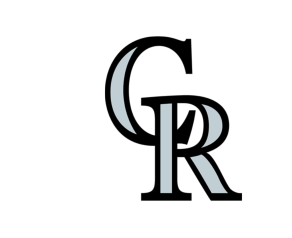

In [2241]:
#LOGOS FOR MLB PLAYERS

def plot_logo(batter_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Construct the URL to fetch team data
    url_team = 'https://statsapi.mlb.com/' + data['people'][0]['currentTeam']['link']

    # Send a GET request to the team URL and parse the JSON response
    data_team = requests.get(url_team).json()

    # Extract the team abbreviation
    team_abb = data_team['teams'][0]['abbreviation']

    # Get the logo URL from the image dictionary using the team abbreviation
    logo_url = image_dict[team_abb]

    # Send a GET request to the logo URL
    response = requests.get(logo_url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Call the plot_logo function with the pitcher ID and a new axis of size 1x1
plot_logo(batter_id, ax=plt.subplots(figsize=(1, 1))[1])

In [2242]:
#ORIGINAL STATS TABLE

# from matplotlib import font_manager

# fangraphs_stats_dict = {
#     'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
#     'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},        # Integer
#     'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},     # Float (3 decimals)
#     'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},     # Integer (rounded)
#     'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},       # Float (3 decimals)
#     'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},       # Float (3 decimals)
#     'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},       # Float (3 decimals)
#     'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},       # Float (3 decimals)
#     'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},
#     'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},
# }

# def fangraphs_batter_stats(batter_id: int, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
#     df_fangraphs = fangraphs_batting_leaderboards(season=season)

#     df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
#     print(df_fangraphs_batter)
        
#     df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
    
    
#     table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center',
#                     bbox=[0.00, 0.0, 1, 1])
#     # Create the table
#     table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

#     # Set font size for each cell's text
#     for key, cell in table_fg.get_celld().items():
#         if cell._text:
#             cell._text.set_fontsize(fontsize)

#     ax.axis('off')

# stats = ['G','PA','AVG','OBP','SLG','OPS','ISO','WAR']
# fangraphs_batter_stats(batter_id = batter_id,
#                         ax = plt.subplots(figsize=(10, 1))[1],
#                         stats = stats,
#                         season = 2024)

       G     PA       AVG       OBP      SLG       OPS       ISO       WAR
0  116.0  458.0  0.218045  0.310722  0.45614  0.766862  0.238095  0.417674


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '458' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompati

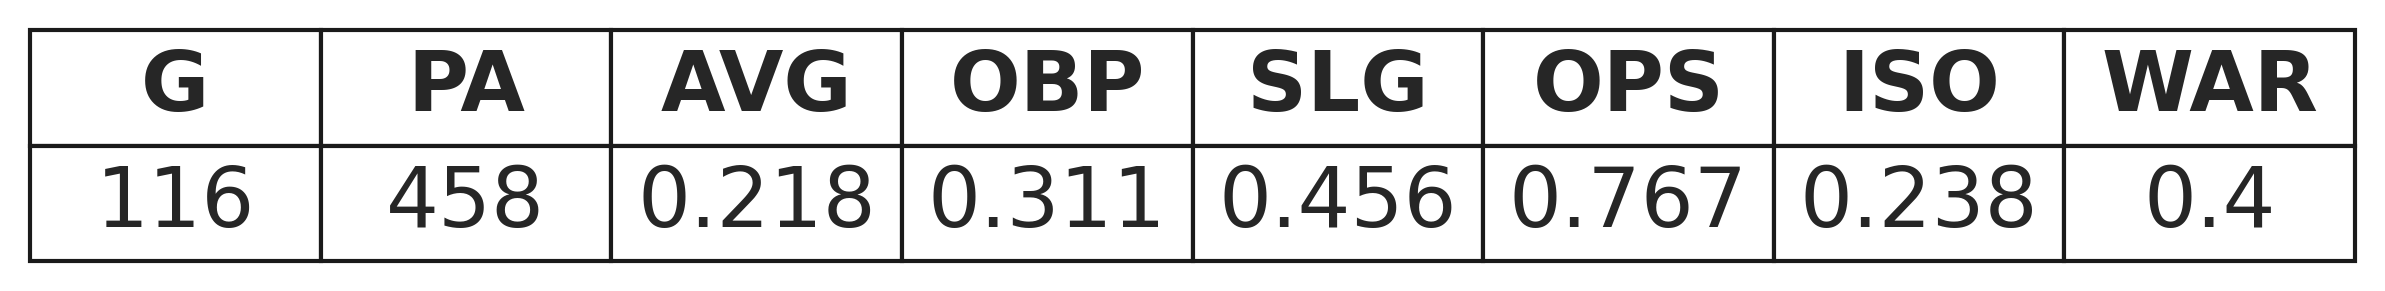

In [2243]:
from matplotlib import font_manager

fangraphs_stats_dict = {
    'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
    'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},        # Integer
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},     # Float (3 decimals)
    'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},     # Integer (rounded)
    'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},       # Float (3 decimals)
    'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},       # Float (3 decimals)
    'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},       # Float (3 decimals)
    'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},       # Float (3 decimals)
    'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},
    'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},
}

def fangraphs_batter_stats(batter_id: str, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
    df_fangraphs = fangraphs_batting_leaderboards(season=season)

    # Convert batter_id to integer to match the type of xMLBAMID
    batter_id = int(batter_id)
    
    # Filter data for the given batter ID
    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    
    # Check if the batter is found
    if df_fangraphs_batter.empty:
        print(f"No data found for batter ID {batter_id}")
    else:
        print(df_fangraphs_batter)
    
        # Format the stats as per the dictionary
        df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
    
        # Create the table
        table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])
        
        # Set font size for each cell's text
        for key, cell in table_fg.get_celld().items():
            if cell._text:
                cell._text.set_fontsize(fontsize,)
        for i, key in enumerate(stats):
            table_fg[0, i]._text.set_fontweight('bold')  # Set column header to bold


        ax.axis('off')


# Example call to display stats
  # Example batter ID
stats = ['G', 'PA', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'WAR']  # Example stats
season = 2024  # Example season

# Create a subplot for the stats table
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the size as needed
fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season)
plt.show()


In [2244]:
# Retrieve the Fangraphs data for inspection
df_fangraphs = fangraphs_batting_leaderboards(season=2024)

# Check the first few rows and column data types
print(df_fangraphs.head())

  Bats  xMLBAMID                                               Name  \
0    R    592450  <a href="statss.aspx?playerid=15640&position=O...   
1    R    677951  <a href="statss.aspx?playerid=25764&position=S...   
2    L    660271  <a href="statss.aspx?playerid=19755&position=D...   
3    L    665742  <a href="statss.aspx?playerid=20123&position=O...   
4    L    683002  <a href="statss.aspx?playerid=26289&position=3...   

                                                Team  Season   Age     AgeR  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  32.0  32 - 32   
1  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  24.0  24 - 24   
2  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  29.0  29 - 29   
3  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  25.0  25 - 25   
4  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  23.0  23 - 23   

   SeasonMin  SeasonMax      G     AB     PA      H     1B    2B    3B    HR  \
0       2024      

In [2245]:
#ORIGINAL HEATMAP VS R

# import matplotlib.patches as patches
# def heatmap_R(df_pyb: pd.DataFrame):
#     # Filter the DataFrame for right-handed pitchers and relevant columns
#     filtered_R_df = df_pyb[
#         (df_pyb['plate_x'].notnull()) & 
#         (df_pyb['plate_z'].notnull()) & 
#         (df_pyb['woba_value'].notnull()) & 
#         (df_pyb['p_throws'] == 'R')
#     ]

#     # Create a DataFrame for the heatmap
#     plate_damage_df = pd.DataFrame({
#         'plate_x': filtered_R_df['plate_x'],
#         'plate_z': filtered_R_df['plate_z'],
#         'damage': filtered_R_df['woba_value']
#     })

#     # Define the corner coordinates for the rectangle
#     min_plate_x = -0.83
#     max_plate_x = 0.83
#     min_plate_z = 1.17
#     max_plate_z = 3.92

#     # Create the heatmap
#     plt.figure(figsize=(5, 3.5))

#     # KDE plot with plate_x and plate_z as the axes, and damage as the color
#     sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9)

#     # Create a rectangle using the given corner coordinates
#     rectangle = patches.Rectangle(
#         (min_plate_x, min_plate_z),  # Lower left corner
#         max_plate_x - min_plate_x,   # Width
#         max_plate_z - min_plate_z,   # Height
#         linewidth=2,                 # Line width
#         edgecolor='black',           # Rectangle border color
#         facecolor='none',            # No fill color inside the rectangle
#         linestyle='-'                # Solid line style
#     )

#     # Add the rectangle to the plot
#     plt.gca().add_patch(rectangle)

#     # Set plot limits and aesthetics
#     plt.xlim(-2.5, 2.5)
#     plt.ylim(0, 5)
#     plt.xticks([])  # Remove x-axis numbers
#     plt.yticks([])  # Remove y-axis numbers
#     plt.grid(False)
#     sns.set(style="white")

#     # Add labels and title
#     plt.title("wOBA Damage vs R")
#     plt.xlabel("")
#     plt.ylabel("")

#     # Show the plot
#     plt.show()

#     # Return the filtered DataFrame for further use
#     return filtered_R_df
# heatmap_df = heatmap_R(df_pyb)


In [2246]:
import matplotlib.patches as patches

def heatmap_R(df_pyb: pd.DataFrame, ax: plt.Axes):  # Add ax parameter here
    # Filter the DataFrame for left-handed pitchers and relevant columns
    filtered_R_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['woba_value'].notnull()) & 
        (df_pyb['p_throws'] == 'R')
    ]

    # Create a DataFrame for the heatmap
    plate_damage_df = pd.DataFrame({
        'plate_x': filtered_R_df['plate_x'],
        'plate_z': filtered_R_df['plate_z'],
        'damage': filtered_R_df['woba_value']
    })

    # Define the corner coordinates for the rectangle
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.17
    max_plate_z = 3.92

    # Create the heatmap on the provided axis
    sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9, ax=ax)

    # Create a rectangle using the given corner coordinates
    rectangle = patches.Rectangle(
        (min_plate_x, min_plate_z),  # Lower left corner
        max_plate_x - min_plate_x,   # Width
        max_plate_z - min_plate_z,   # Height
        linewidth=2,                 # Line width
        edgecolor='black',           # Rectangle border color
        facecolor='none',            # No fill color inside the rectangle
        linestyle='-'                # Solid line style
    )

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Set plot limits and aesthetics
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5)
    ax.set_xticks([])  # Remove x-axis numbers
    ax.set_yticks([])  # Remove y-axis numbers
    ax.grid(False)
    sns.set(style="white")

    # Add labels and title
    ax.set_title("wOBA Damage vs R", fontweight='bold', fontsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return filtered_R_df


In [2247]:
#ORIGINAL HEATMAP VS L

# import matplotlib.patches as patches

# def heatmap_L(df_pyb: pd.DataFrame):
#     # Filter the DataFrame for left-handed pitchers and relevant columns
#     filtered_L_df = df_pyb[
#         (df_pyb['plate_x'].notnull()) & 
#         (df_pyb['plate_z'].notnull()) & 
#         (df_pyb['woba_value'].notnull()) & 
#         (df_pyb['p_throws'] == 'L')
#     ]

#     # Create a DataFrame for the heatmap
#     plate_damage_df = pd.DataFrame({
#         'plate_x': filtered_L_df['plate_x'],
#         'plate_z': filtered_L_df['plate_z'],
#         'damage': filtered_L_df['woba_value']
#     })

#     # Define the corner coordinates for the rectangle
#     min_plate_x = -0.83
#     max_plate_x = 0.83
#     min_plate_z = 1.17
#     max_plate_z = 3.92

#     # Create the heatmap
#     plt.figure(figsize=(5, 3.5))

#     # KDE plot with plate_x and plate_z as the axes, and damage as the color
#     sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9)

#     # Create a rectangle using the given corner coordinates
#     rectangle = patches.Rectangle(
#         (min_plate_x, min_plate_z),  # Lower left corner
#         max_plate_x - min_plate_x,   # Width
#         max_plate_z - min_plate_z,   # Height
#         linewidth=2,                 # Line width
#         edgecolor='black',           # Rectangle border color
#         facecolor='none',            # No fill color inside the rectangle
#         linestyle='-'                # Solid line style
#     )

#     # Add the rectangle to the plot
#     plt.gca().add_patch(rectangle)

#     # Set plot limits and aesthetics
#     plt.xlim(-2.5, 2.5)
#     plt.ylim(0, 5)
#     plt.xticks([])  # Remove x-axis numbers
#     plt.yticks([])  # Remove y-axis numbers
#     plt.grid(False)
#     sns.set(style="white")

#     # Add labels and title
#     plt.title("wOBA Damage vs L")
#     plt.xlabel("")
#     plt.ylabel("")

#     # Show the plot
#     plt.show()

#     # Return the filtered DataFrame for further use
#     return filtered_L_df

# heatmap_df_L = heatmap_L(df_pyb)


In [2248]:
import matplotlib.patches as patches

def heatmap_L(df_pyb: pd.DataFrame, ax: plt.Axes):  # Add ax parameter here
    # Filter the DataFrame for left-handed pitchers and relevant columns
    filtered_L_df = df_pyb[
        (df_pyb['plate_x'].notnull()) & 
        (df_pyb['plate_z'].notnull()) & 
        (df_pyb['woba_value'].notnull()) & 
        (df_pyb['p_throws'] == 'L')
    ]

    # Create a DataFrame for the heatmap
    plate_damage_df = pd.DataFrame({
        'plate_x': filtered_L_df['plate_x'],
        'plate_z': filtered_L_df['plate_z'],
        'damage': filtered_L_df['woba_value']
    })

    # Define the corner coordinates for the rectangle
    min_plate_x = -0.83
    max_plate_x = 0.83
    min_plate_z = 1.17
    max_plate_z = 3.92

    # Create the heatmap on the provided axis
    sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=0.9, ax=ax)

    # Create a rectangle using the given corner coordinates
    rectangle = patches.Rectangle(
        (min_plate_x, min_plate_z),  # Lower left corner
        max_plate_x - min_plate_x,   # Width
        max_plate_z - min_plate_z,   # Height
        linewidth=2,                 # Line width
        edgecolor='black',           # Rectangle border color
        facecolor='none',            # No fill color inside the rectangle
        linestyle='-'                # Solid line style
    )

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Set plot limits and aesthetics
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5)
    ax.set_xticks([])  # Remove x-axis numbers
    ax.set_yticks([])  # Remove y-axis numbers
    ax.grid(False)
    sns.set(style="white")

    # Add labels and title
    ax.set_title("wOBA Damage vs L", fontweight='bold', fontsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return filtered_L_df


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1014066196.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Use a diverging colormap


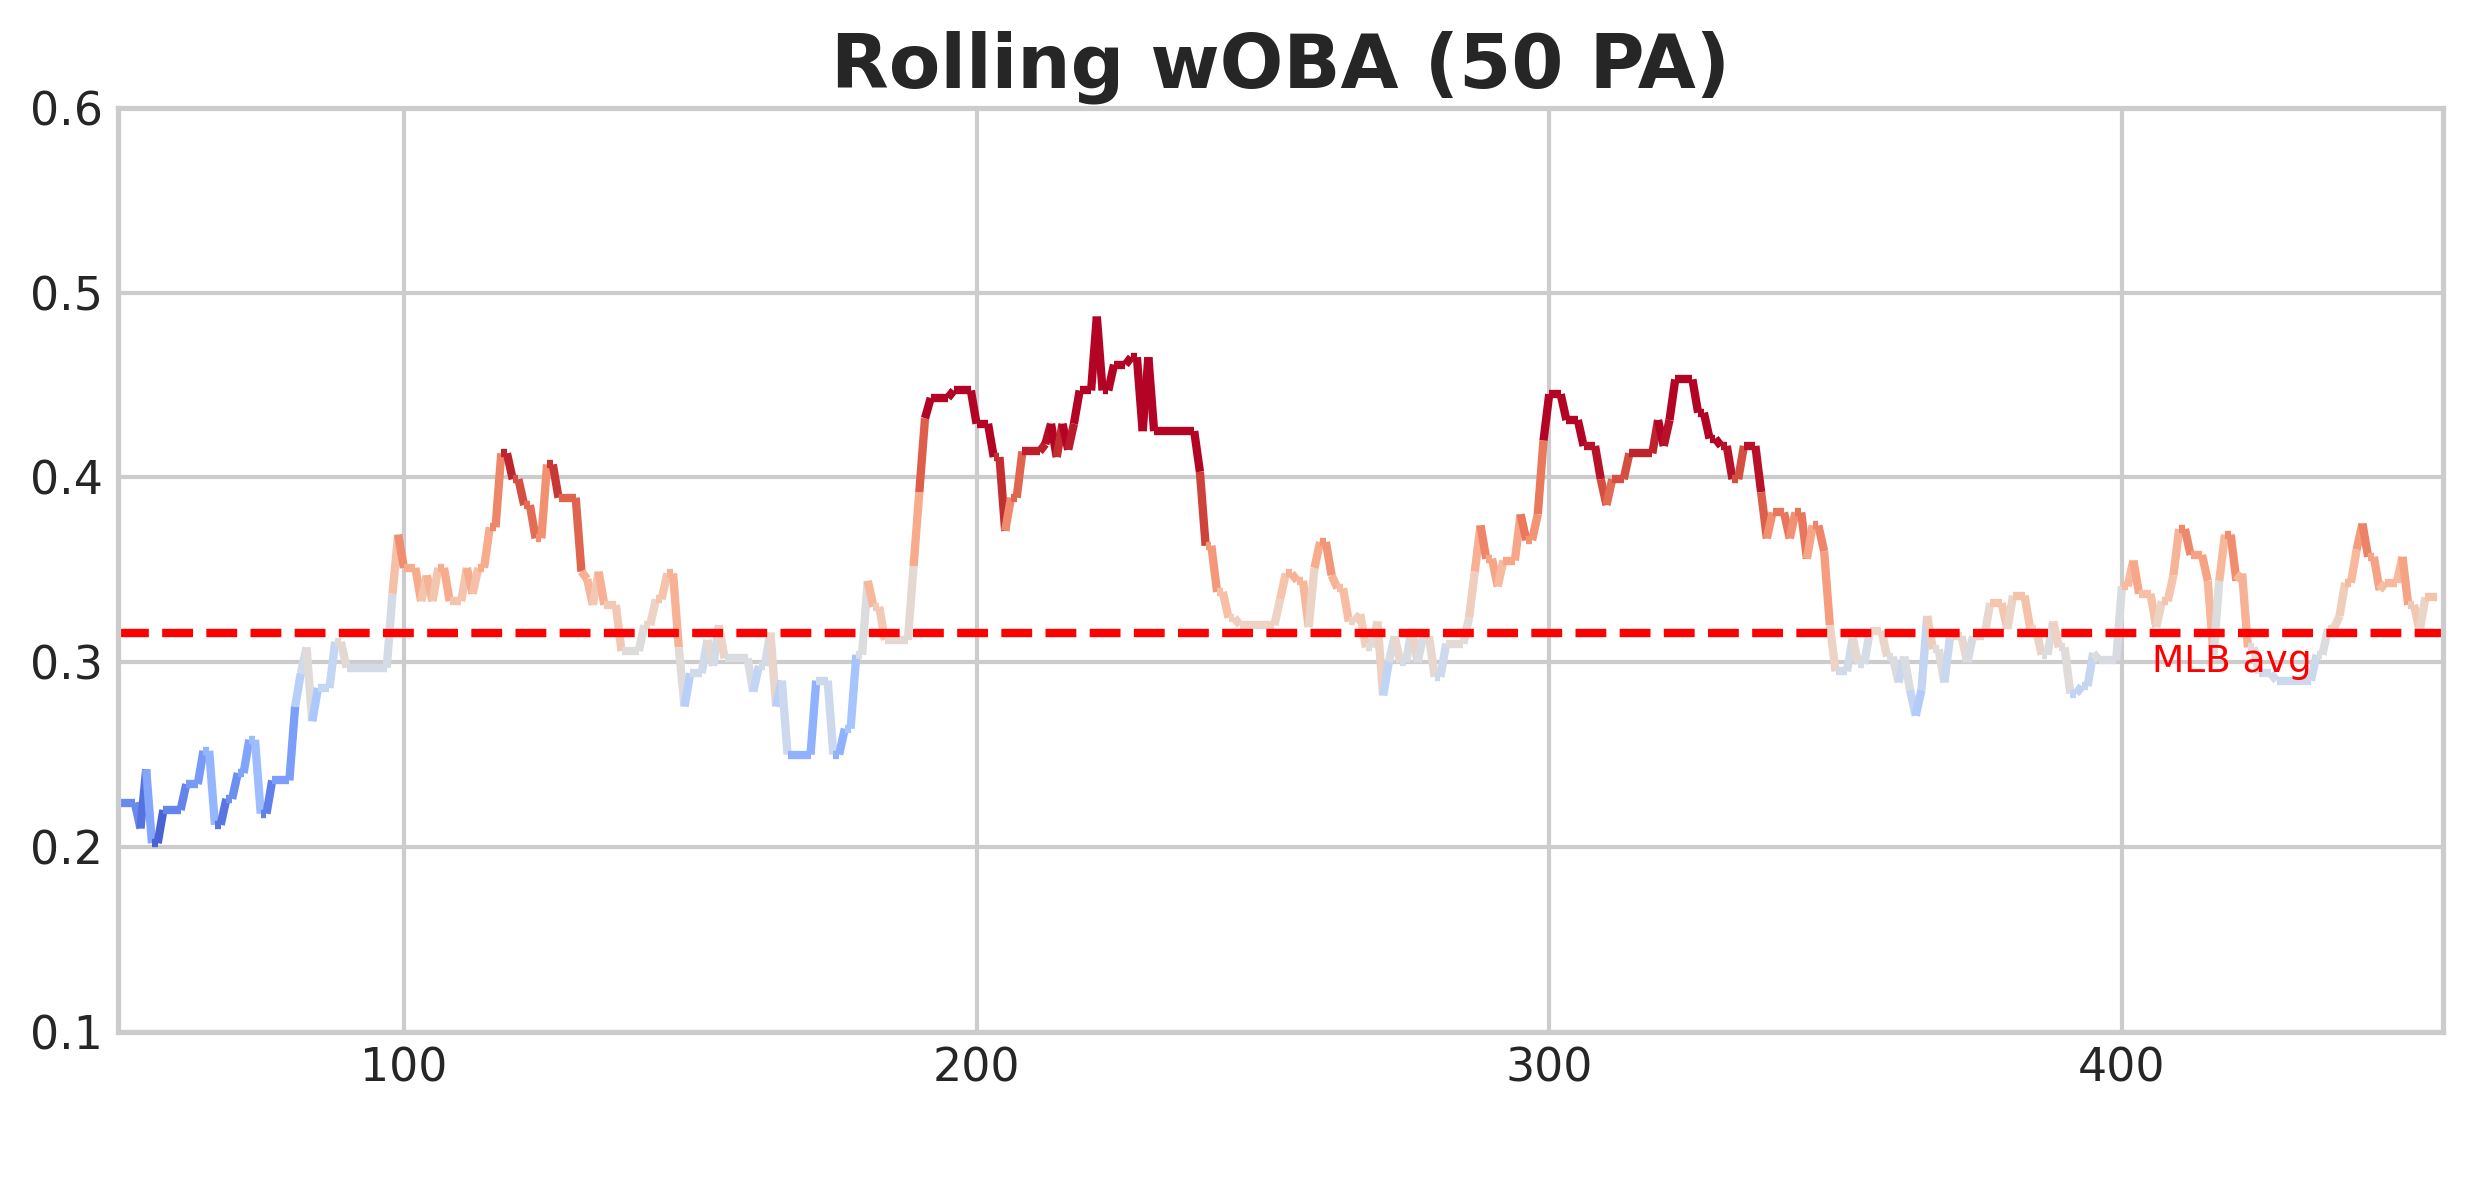

In [2249]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

def rolling_woba_by_pa(df: pd.DataFrame, ax: plt.Axes, window: int):
    # Drop rows where 'woba_value' or 'plate_x' and 'plate_z' are NaN
    df = df.dropna(subset=['woba_value', 'plate_x', 'plate_z'])

    # Reverse the DataFrame order
    df = df.iloc[::-1].reset_index(drop=True)
    
    # Calculate wOBA rolling window by PA (plate appearance)
    df['rolling_woba'] = df['woba_value'].rolling(window=window).mean()
    
    # Generate x and y data for the plot
    x = np.arange(len(df))
    y = df['rolling_woba'].values

    # Create segments for the LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Define color based on the y value crossing the 0.316 threshold
    colors = ['blue' if y_ < 0.316 else 'red' for y_ in y]
    cmap = plt.cm.get_cmap('coolwarm')  # Use a diverging colormap
    lc = LineCollection(
        segments, 
        cmap=cmap, 
        norm=plt.Normalize(vmin=0.19, vmax=0.42),  # Adjust normalization as needed
        linewidth=2
    )
    lc.set_array(y)  # Color by y-values
    ax.add_collection(lc)

    # Plot the rolling wOBA against Plate Appearances
    ax.plot(x, y, alpha=0)  # Transparent line for proper scaling
    
    # Adjust axis labels and title with smaller fonts and closer to graph
    ax.set_xlabel(' ', fontdict={'size':12}, fontweight='bold')  # Smaller x-axis label font size
    ax.set_ylabel(' ', fontdict={'size': 12}, labelpad=-15, fontweight='bold')  # Smaller y-axis label font size and closer to the axis
    ax.set_title(f'Rolling wOBA ({window} PA)', fontdict={'size': 18}, pad=5,fontweight='bold')  # Smaller title font size and adjusted padding

    # Format y-axis to show three decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Set x-axis to show integer values only (i.e., PA numbers)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=11, labelleft=True, labelbottom=True)  # Smaller font size for tick labels
    
    # Set the tick labels inside the graph
    ax.tick_params(axis='x', direction='in', length=6)  # Move x-axis ticks inside
    ax.tick_params(axis='y', direction='in', length=6)  # Move y-axis ticks inside

    ax.set_xticks(np.arange(0, len(df), 100))

    # Optional: Adjust x and y axis limits
    ax.set_xlim(50, len(df))  # Set x-axis range from 0 to the length of the data
    ax.set_ylim(.1, 0.600)      # Example: limit y-axis to range from 0 to 0.5 for rolling wOBA
    
    # Add dashed red line at y = 0.316 (MLB average)
    ax.axhline(y=0.316, color='red', linestyle='--', linewidth=2)
    
    
    xlim_right = ax.get_xlim()[1]

    # Add label for the dashed line on the right side of the graph
    ax.text(xlim_right * .95, 0.3, 'MLB avg', color='red', fontsize=9, va='center', ha='right')

    plt.show()

filtered_df = df_pyb[(df_pyb['events'].notnull())]
# Example usage
rolling_woba_by_pa(filtered_df, ax=plt.subplots(figsize=(10, 4))[1], window=50)


In [2250]:
#Original ADVANCED FANGRAPHS STATS
# from matplotlib import font_manager
# from matplotlib.colors import Normalize
# from matplotlib.cm import ScalarMappable

# fangraphs_stats_dict = {
#     'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
#     'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},       # Integer
#     'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},     # Float (3 decimals)
#     'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},     # Float (3 decimals)
#     'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},     # Float (3 decimals)
#     'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},     # Float (3 decimals)
#     'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},     # Float (3 decimals)
#     'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},     # Float (1 decimal)
#     'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},   # Float (3 decimals)
#     'xwOBA': {'table_header': '$\\bf{xwOBA}$', 'format': '.3f'}, # Float (3 decimals)
#     'K%': {'table_header': '$\\bf{K\\%}$', 'format': '.1f'},  # Percentage (1 decimal)
#     'BB%': {'table_header': '$\\bf{BB\\%}$', 'format': '.1f'},  # Percentage (1 decimal)
#     'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},   # Integer (rounded)
#     'LA': {'table_header': '$\\bf{LA}$', 'format': '.1f'},       # Float (1 decimal)
#     'EV': {'table_header': '$\\bf{EV}$', 'format': '.1f'},       # Float (1 decimal)
#     'MaxEV': {'table_header': '$\\bf{MaxEV}$', 'format': '.1f'}, # Float (1 decimal)
#     'HardHit%': {'table_header': '$\\bf{HardHit\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
#     'Z-Swing%': {'table_header': '$\\bf{Z-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
#     'O-Swing%': {'table_header': '$\\bf{O-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
#     'OAA': {'table_header': '$\\bf{OAA}$', 'format': '.0f'},     # Integer
#     'DRS': {'table_header': '$\\bf{DRS}$', 'format': '.0f'}      # Integer
# }


# league_averages = {
#     'AVG': 0.250,
#     'OBP': 0.320,
#     'SLG': 0.420,
#     'OPS': 0.740,
#     'ISO': 0.140,
#     'WAR': 2.0,
#     'wOBA': 0.320,
#     'xwOBA': 0.317,
#     'K%': 21.3,
#     'BB%': 9.0,
#     'wRC+': 100,
#     'LA': 13.5,
#     'EV': 88.0,
#     'MaxEV': 109.2,
#     'HardHit%': 40.0,
#     'Z-Swing%': 60.0,
#     'O-Swing%': 30.0,
#     'OAA': 0,
#     'DRS': 0
# }


# def adv_fangraphs_batter_stats(batter_id: str, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
#     df_fangraphs = fangraphs_batting_leaderboards(season=season)

#     # Convert batter_id to integer to match the type of xMLBAMID
#     batter_id = int(batter_id)
    
#     # Filter data for the given batter ID
#     df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    
#     # Check if the batter is found
#     if df_fangraphs_batter.empty:
#         print(f"No data found for batter ID {batter_id}")
#     else:
#         print(df_fangraphs_batter)
    
#         # Modify percentage stats (K%, BB%, HardHit%, Z-Swing%, O-Swing%) by multiplying by 100
#         for stat in stats:
#             if '%' in stat:  # For percentage metrics
#                 df_fangraphs_batter[stat] = df_fangraphs_batter[stat] * 100

#         # Format the stats as per the dictionary
#         df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
    
#         # Create the table
#         table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])
        
#         for i, stat in enumerate(stats):
#             league_avg = league_averages.get(stat, None)
#             if league_avg:
#                 stat_value = float(df_fangraphs_batter[stat].iloc[0])  # Convert to float
#                 # Get the actual stat value
#                 stat_value = df_fangraphs_batter[stat].iloc[0]
#                 # Normalize the difference to create a color mapping
#                 norm = Normalize(vmin=league_avg * 0.8, vmax=league_avg * 1.2)  # Slight tolerance around league average
#                 cmap = plt.get_cmap('coolwarm')  # Blue to Red gradient
#                 color = ScalarMappable(norm=norm, cmap=cmap).to_rgba(stat_value)

#                 # Apply color to the cell
#                 table_fg[(1, i)].set_facecolor(color)  # Cell at row 1 (stat row)

#         # Set font size for each cell's text
#         for key, cell in table_fg.get_celld().items():
#             if cell._text:
#                 cell._text.set_fontsize(fontsize,)
#         for i, key in enumerate(stats):
#             table_fg[0, i]._text.set_fontweight('bold')  # Set column header to bold


#         ax.axis('off')

# # Example call to display stats
# batter_id = 592450  # Example batter ID
# stats = ['wRC+','wOBA', 'xwOBA', 'K%', 'BB%', 'LA', 'EV','HardHit%', 'Z-Swing%', 'O-Swing%',]
#   # Example stats
# season = 2024  # Example season

# # Create a subplot for the stats table
# fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the size as needed
# adv_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season)
# plt.show()


In [2251]:
df_fangraphs.columns = df_fangraphs.columns.str.strip()  # Strip any leading/trailing whitespace


Stats list: ['wRC+', 'wOBA', 'xwOBA', 'K%', 'BB%', 'EV', 'maxEV', 'HardHit%', 'Barrel%', 'Z-Swing%', 'O-Swing%']
Available columns: Index(['Bats', 'xMLBAMID', 'Name', 'Team', 'Season', 'Age', 'AgeR',
       'SeasonMin', 'SeasonMax', 'G',
       ...
       'TG', 'TPA', 'PlayerNameRoute', 'PlayerName', 'position', 'playerid',
       'TeamName', 'TeamNameAbb', 'teamid', 'Pos'],
      dtype='object', length=359)
        wRC+     wOBA  xwOBA        K%       BB%         EV    maxEV  \
0  98.162634  0.32924  0.358  0.320961  0.117904  92.158744  111.977   

   HardHit%   Barrel%  Z-Swing%  O-Swing%  
0       0.5  0.171875  0.692206  0.291488  


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '98' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.329' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.358' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraph

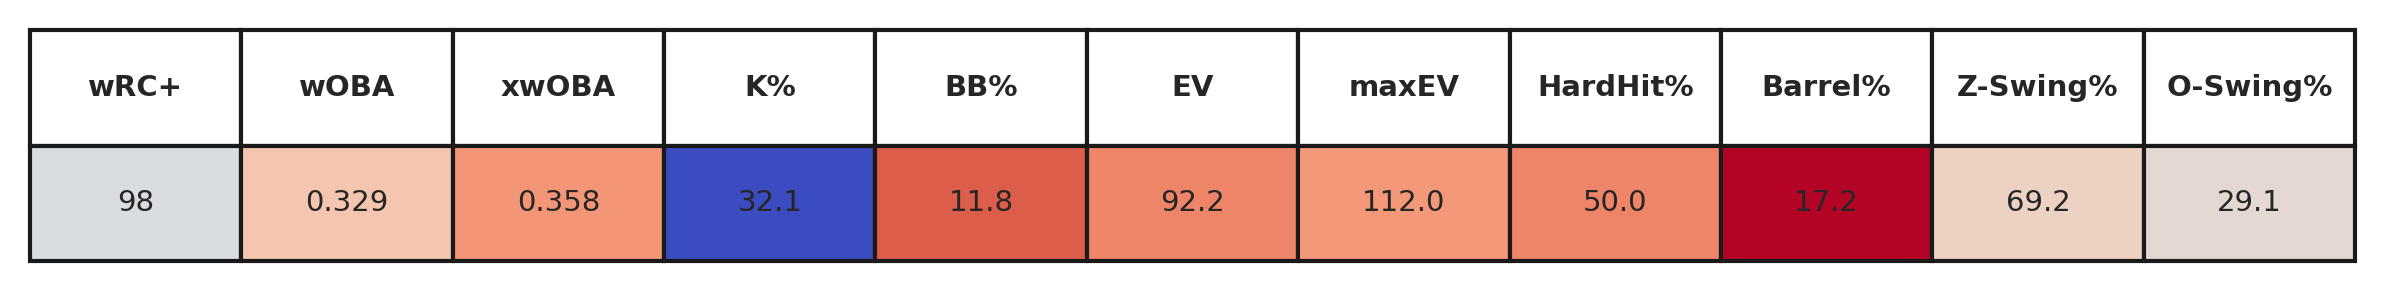

In [2252]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fangraphs_stats_dict = {
    'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
    'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},       # Integer
    'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},     # Float (3 decimals)
    'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},     # Float (3 decimals)
    'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},     # Float (3 decimals)
    'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},     # Float (3 decimals)
    'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},     # Float (3 decimals)
    'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},     # Float (1 decimal)
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},   # Float (3 decimals)
    'xwOBA': {'table_header': '$\\bf{xwOBA}$', 'format': '.3f'}, # Float (3 decimals)
    'K%': {'table_header': '$\\bf{K\\%}$', 'format': '.1f'},  # Percentage (1 decimal)
    'BB%': {'table_header': '$\\bf{BB\\%}$', 'format': '.1f'},  # Percentage (1 decimal)
    'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},   # Integer (rounded)
    'LA': {'table_header': '$\\bf{LA}$', 'format': '.1f'},       # Float (1 decimal)
    'EV': {'table_header': '$\\bf{EV}$', 'format': '.1f'},       # Float (1 decimal)
    'maxEV': {'table_header': '$\\bf{maxEV}$', 'format': '.1f'}, # Float (1 decimal)
    'HardHit%': {'table_header': '$\\bf{HardHit\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Barrel%': {'table_header': '$\\bf{Barrel\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Z-Swing%': {'table_header': '$\\bf{Z-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'O-Swing%': {'table_header': '$\\bf{O-Swing\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'Chase%': {'table_header': '$\\bf{Chase\\%}$', 'format': '.1f'}, # Percentage (1 decimal)
    'OAA': {'table_header': '$\\bf{OAA}$', 'format': '.0f'},     # Integer
    'DRS': {'table_header': '$\\bf{DRS}$', 'format': '.0f'}      # Integer
}

# Sample league averages for each stat (replace with actual data)
league_averages = {
    'AVG': 0.243,
    'OBP': 0.320,
    'SLG': 0.399,
    'OPS': 0.740,
    'ISO': 0.140,
    'WAR': 2.0,
    'wOBA': 0.310,
    'xwOBA': 0.312,
    'K%': -21.3,
    'BB%': 8.0,
    'wRC+': 100,
    'LA': 13.5,
    'EV': 89.3,
    'maxEV': 109.,
    'HardHit%': 40.0,
    'Barrel%': 9.0,
    'Z-Swing%': 65.0,
    'O-Swing%': 30.0,
    'Chase%': 28.2,
    'OAA': 0,
    'DRS': 0
}



def adv_fangraphs_batter_stats(batter_id: str, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
    df_fangraphs = fangraphs_batting_leaderboards(season=season)

    # Convert batter_id to integer to match the type of xMLBAMID
    batter_id = int(batter_id)
    
    # Filter data for the given batter ID
    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    
    # Check if the batter is found
    if df_fangraphs_batter.empty:
        print(f"No data found for batter ID {batter_id}")
    else:
        print(df_fangraphs_batter)
    
        # Ensure percentage stats are converted to float
        for stat in stats:
            if '%' in stat:  # For percentage metrics
                df_fangraphs_batter[stat] = df_fangraphs_batter[stat] * 100
        
        # Format the stats as per the dictionary
        df_fangraphs_batter.loc[0] = [
            format(float(df_fangraphs_batter[stat].iloc[0]), fangraphs_stats_dict[stat]['format']) 
            for stat in stats
        ]
        # Create the table
        table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

        # Custom normalization ranges for each stat based on league averages
        custom_normalization = {
            'AVG': {'vmin': 0.190, 'vmax': 0.350},  # Lower bound for batting average
            'OBP': {'vmin': 0.250, 'vmax': 0.450},
            'SLG': {'vmin': 0.340, 'vmax': 0.600},
            'OPS': {'vmin': 0.600, 'vmax': 1.100},
            'ISO': {'vmin': 0.075, 'vmax': 0.300},
            'WAR': {'vmin': 0.0, 'vmax': 10.0},  # WAR can go above 10
            'wOBA': {'vmin': 0.230, 'vmax': 0.390},
            'xwOBA': {'vmin': 0.240, 'vmax': 0.395},
            'K%': {'vmin': -32.0, 'vmax': -13.0},  # Flip range for K%
            'BB%': {'vmin': 3.0, 'vmax': 13.0},
            'wRC+': {'vmin': 20, 'vmax': 180},
            'LA': {'vmin': 5.0, 'vmax': 25.0},
            'EV': {'vmin': 85, 'vmax': 94},
            'maxEV': {'vmin': 103, 'vmax': 115},
            'HardHit%': {'vmin': 22.0, 'vmax': 57.0},
            'Barrel%': {'vmin': 1.0, 'vmax': 17.0},
            'Z-Swing%': {'vmin': 55.0, 'vmax': 80.0},
            'O-Swing%': {'vmin': -45.0, 'vmax': -15.0},  # Flip range for O-Swing%
            'Chase%': {'vmin': 10.0, 'vmax': 50.0},
            'OAA': {'vmin': -20, 'vmax': 20},  # For fielding, OAA is best when positive
            'DRS': {'vmin': -20, 'vmax': 20},  # For fielding, DRS is best when positive
        }

        # Normalize the stats values based on league averages
        for i, stat in enumerate(stats):
            league_avg = league_averages.get(stat, None)
            if league_avg:
                # Explicitly ensure that the stat value is a float
                stat_value = float(df_fangraphs_batter[stat].iloc[0])  # Convert to float

                # Handle flipped stats
                if stat in ['K%', 'O-Swing%']:
                    # Flip the stat value for normalization and adjust range
                    stat_value = -stat_value

                # Use the custom normalization for each stat if defined
                if stat in custom_normalization:
                    norm_params = custom_normalization[stat]
                    vmin, vmax = norm_params['vmin'], norm_params['vmax']
                else:
                    # Default to a broader range for other stats if no custom range is provided
                    vmin = league_avg * 0.8  # Normal range for other stats
                    vmax = league_avg * 1.2

                # Apply the color mapping
                norm = colors.Normalize(vmin=vmin, vmax=vmax)
                cmap = plt.get_cmap('coolwarm')  # Blue to Red gradient
                color = ScalarMappable(norm=norm, cmap=cmap).to_rgba(stat_value)

                # Apply color to the cell
                table_fg[(1, i)].set_facecolor(color)  # Cell at row 1 (stat row)

        # Set font size for each cell's text
        for key, cell in table_fg.get_celld().items():
            if cell._text:
                cell._text.set_fontsize(fontsize)
        for i, key in enumerate(stats):
            table_fg[0, i]._text.set_fontweight('bold')  # Set column header to bold

        ax.axis('off')



# Example call to display stats
#batter_id = 665833  # Example batter ID
stats = ['wRC+','wOBA', 'xwOBA', 'K%', 'BB%', 'EV','maxEV','HardHit%','Barrel%', 'Z-Swing%', 'O-Swing%']
  # Example stats
season = 2024  # Example season

print("Stats list:", stats)
print("Available columns:", df_fangraphs.columns)

# Create a subplot for the stats table
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the size as needed
adv_fangraphs_batter_stats(batter_id=batter_id, ax=ax, stats=stats, season=season)
plt.show()


In [2253]:
print(df_fangraphs['EV'].dtype)  # Check the type of the 'maxEV' column


float64


In [2254]:
print(pyb.playerid_lookup('Cruz','Oneil'))
batter_id = batter_id
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
# df_pyb.head()

#print(df['column_name'].unique())

  name_last name_first  key_mlbam key_retro key_bbref  key_fangraphs  \
0      cruz      oneil     665833  cruzo001  cruzon01          21711   

   mlb_played_first  mlb_played_last  
0            2021.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'fld_scor

Gathering Player Data
       G     PA       AVG       OBP       SLG       OPS       ISO       WAR
0  153.0  561.0  0.242485  0.320856  0.446894  0.767749  0.204409  4.001896


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '153' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '561' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0], fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1093488577.py:32: FutureWarning: Setting an item of incompati

       wRC+      wOBA  xwOBA        K%       BB%         EV    maxEV  \
0  119.5689  0.331457  0.326  0.306595  0.092692  90.484921  113.593   

   HardHit%   Barrel%  Z-Swing%  O-Swing%  
0  0.451515  0.136364  0.662978  0.276386  


/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.331' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [
/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_76552/1993415320.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.326' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangrap

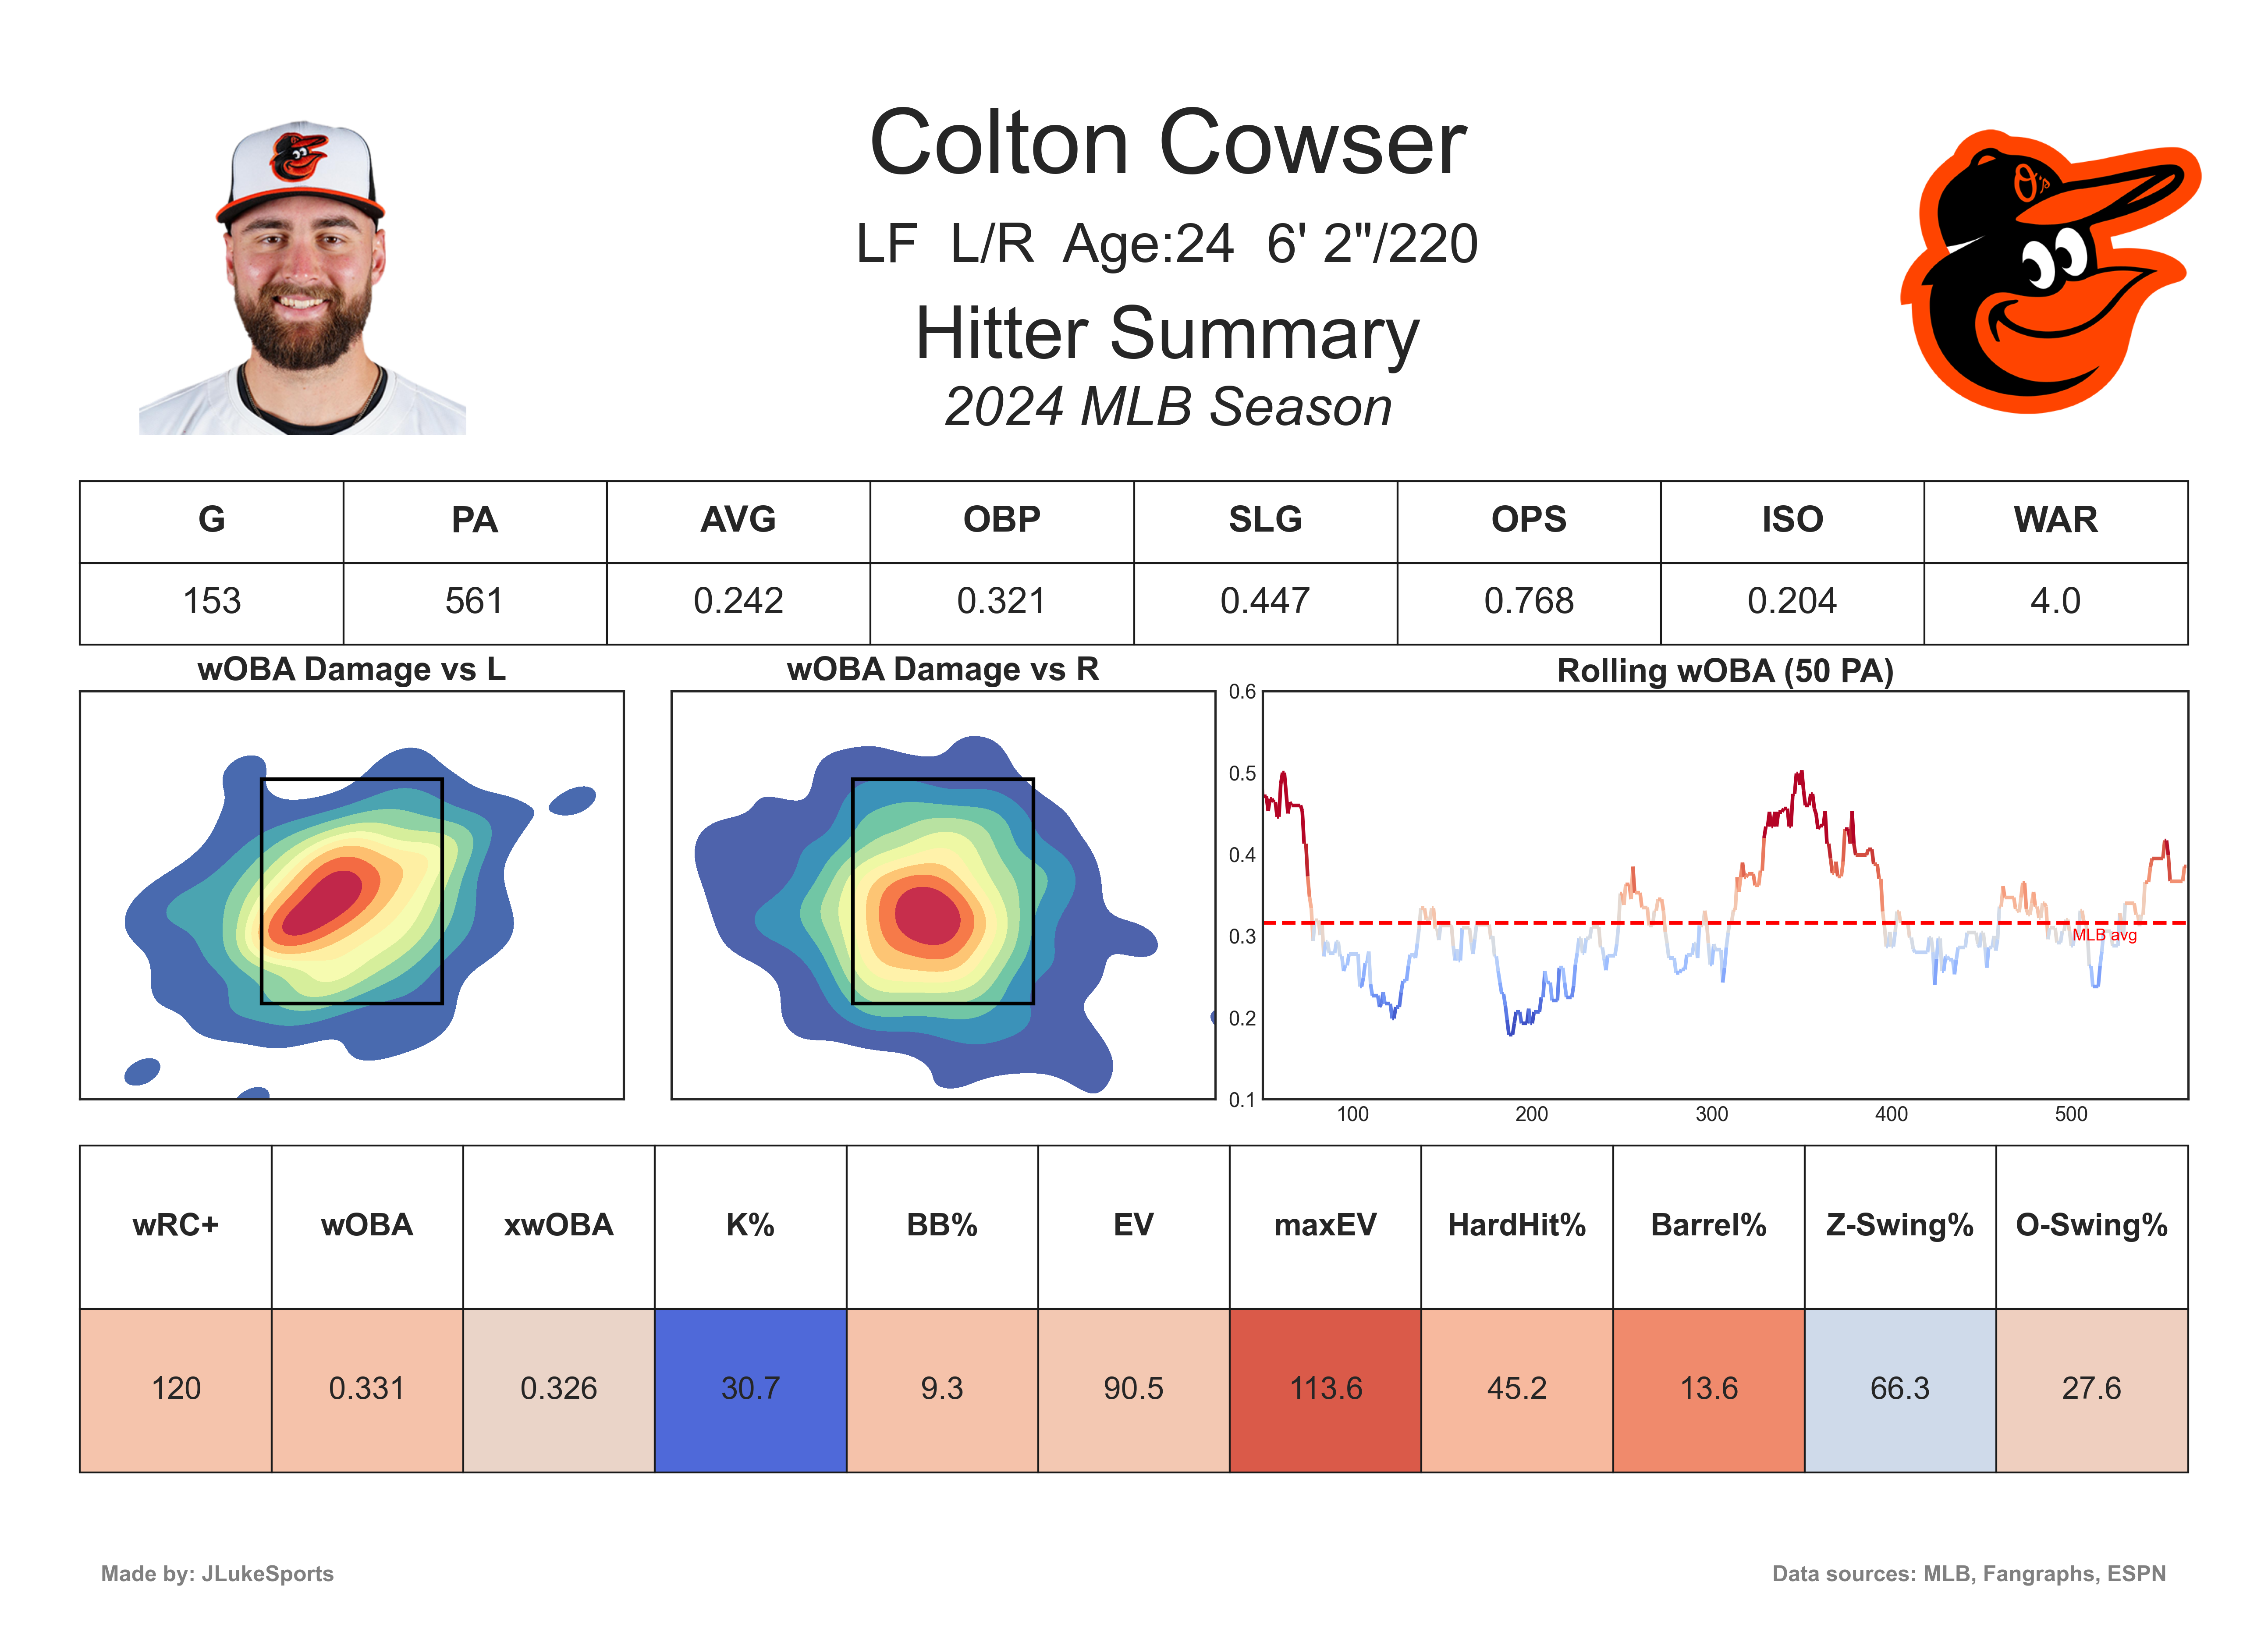

<Figure size 1920x1440 with 0 Axes>

In [2266]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def hitting_dashboard(batter_id: str, df: pd.DataFrame, stats: list, window: int):
    # Process the DataFrame and initialize the figure
    df = df_processing(df)  # Ensure data processing
    fig = plt.figure(figsize=(22, 16))

    # Define gridspec for the layout
    gs = gridspec.GridSpec(6, 8,
                        height_ratios=[3, 20, 10, 25, 20, 7],  # Increased height for rolling wOBA plot (row 3)
                        width_ratios=[1, 13, 13, 13, 13, 23, 23, 1])

    # Define subplots
    ax_headshot = fig.add_subplot(gs[1, 1:3])
    ax_bio = fig.add_subplot(gs[1, 1:8])
    ax_logo = fig.add_subplot(gs[1, 6:8])
    
    ax_season_table = fig.add_subplot(gs[2, 1:7])

    ax_plot_1 = fig.add_subplot(gs[3, 1:3])
    ax_plot_2 = fig.add_subplot(gs[3, 3:5])
    ax_plot_3 = fig.add_subplot(gs[3, 5:7])

    ax_table = fig.add_subplot(gs[4, 1:7])

    ax_footer = fig.add_subplot(gs[-1, 1:7])
    ax_header = fig.add_subplot(gs[0, 1:7])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, header, left, and right
    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

# Add Twitter handle to the bottom-left and sources to the bottom-right
    sources = "Data sources: MLB, Fangraphs, ESPN"

# Add Twitter handle to the bottom-left
    ax_footer.text(0.01, 0.5, f"Made by: JLukeSports", 
               ha='left', va='center', 
               fontsize=12, color='gray', 
               fontweight='bold', 
               transform=ax_footer.transAxes)

# Add sources to the bottom-right
    ax_footer.text(0.99, 0.5, sources, 
               ha='right', va='center', 
               fontsize=12, color='gray', 
               fontweight='bold', 
               transform=ax_footer.transAxes)


    # Load and display player visuals
    player_headshot(batter_id, ax=ax_headshot)
    player_bio(batter_id, ax=ax_bio)
    plot_logo(batter_id, ax=ax_logo) #add season if using Dom function

    # Display Season Stats Table
    fangraphs_batter_stats(batter_id, ax=ax_season_table, stats=stats, season=season)
    adv_fangraphs_batter_stats(batter_id, ax=ax_table, stats=['wRC+','wOBA', 'xwOBA', 'K%', 'BB%', 'EV','maxEV','HardHit%','Barrel%', 'Z-Swing%', 'O-Swing%',], season=season)
    # Plot the heatmaps for right-handed and left-handed pitchers
    heatmap_L(df, ax=ax_plot_1)
    heatmap_R(df, ax=ax_plot_2)
    rolling_woba_by_pa(df, ax=ax_plot_3, window=window)

    ax_plot_1.set_aspect('auto')
    ax_plot_2.set_aspect('auto')

    # Adjust title and label spacing to ensure no clipping
    ax_plot_3.set_title(f'Rolling wOBA ({window} PA)', fontsize=16, pad=30)  # Title padding
    ax_plot_3.set_ylabel('wOBA', fontsize=14, labelpad=20)  # Y-axis label padding

    fig.subplots_adjust(hspace=1.0, wspace=1, bottom=0.1) 

    # Show the final dashboard
    plt.tight_layout()
    plt.show()

# Define your batter_id, dataframe (df_pyb), and stats list
batter_id = "681297"  # Example batter ID
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id) # Your dataset
stats = ['G', 'PA', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'WAR']  # Example stats you want to display
window = 50  # Example window size for rolling wOBA

# Call the dashboard function
hitting_dashboard(batter_id=batter_id, df=df_pyb, stats=stats, window=window)


In [2265]:
print(pyb.playerid_lookup('Cowser','Colton'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    cowser     colton     681297  cowsc001  cowseco01          29591   

   mlb_played_first  mlb_played_last  
0            2023.0           2024.0  
